### S.Y. Huang et al, Phys. Rev. A 88, 6 2013

This article proposes a feedback implementation for the production of W qubit states open to the enviroment.

In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import qt_unraveling as qtr

import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%load_ext autotime
%load_ext line_profiler

In [2]:
## Useful definitions and matrices
Sigmax_1 = np.kron(np.kron(qtr.sigmax,np.eye(2)),np.eye(2))
Sigmax_2 = np.kron(np.kron(np.eye(2),qtr.sigmax),np.eye(2))
Sigmax_3 = np.kron(np.kron(np.eye(2),np.eye(2)),qtr.sigmax)

Sigmaz_1 = np.kron(np.kron(qtr.sigmaz,np.eye(2)),np.eye(2))
Sigmaz_2 = np.kron(np.kron(np.eye(2),qtr.sigmaz),np.eye(2))
Sigmaz_3 = np.kron(np.kron(np.eye(2),np.eye(2)),qtr.sigmaz)
Aux1 = Sigmaz_1 + Sigmaz_2 + Sigmaz_3

Sigmap_1 = np.kron(np.kron(qtr.sigmap,np.eye(2)),np.eye(2))
Sigmap_2 = np.kron(np.kron(np.eye(2),qtr.sigmap),np.eye(2))
Sigmap_3 = np.kron(np.kron(np.eye(2),np.eye(2)),qtr.sigmap)
Sigmap = np.array([Sigmap_1, Sigmap_2, Sigmap_3])
Aux2 = np.sum(Sigmap)

Sigmam_1 = np.kron(np.kron(qtr.sigmam,np.eye(2)),np.eye(2))
Sigmam_2 = np.kron(np.kron(np.eye(2),qtr.sigmam),np.eye(2))
Sigmam_3 = np.kron(np.kron(np.eye(2),np.eye(2)),qtr.sigmam)
Sigmam = np.array([Sigmam_1, Sigmam_2, Sigmam_3])
Aux3 = np.sum(Sigmam)

Aux4 = np.zeros((8, 8), dtype = np.complex128)
temp1 = [np.eye(2),np.eye(2),np.eye(2)]
temp2 = [np.eye(2),np.eye(2),np.eye(2)]

for i in range(3):
    temp1[i] = qtr.sigmam
    temp2[i] = qtr.sigmap
    for j in range(3):
        if i != j:
            temp1[j] = qtr.sigmap
            temp2[j] = qtr.sigmam
            Aux4 += np.kron(np.kron(temp1[0],temp1[1]), temp1[2]) + np.kron(np.kron(temp2[0],temp2[1]), temp2[2])
            temp1[j] = np.eye(2)
            temp2[j] = np.eye(2)
    temp1[i] = np.eye(2)
    temp2[i] = np.eye(2)
#########################################################

time: 38.6 ms


The set of parameters that characterize the system is taken as the ones indicated by the authors

In [3]:
### Parameters
kappa = 1
epsilon = 2*kappa
chi = -0.11*kappa
g = 10*kappa
eta = 1
lamb = chi/g
Delta = g*g/chi
gamma_1 = 4*kappa*1e-3
gamma_2 = 4*kappa*1e-3
gamma_3 = 4*kappa*1e-3

time: 16 ms


Next we define the logic base |ijk> 

In [4]:
## In order the base corresponds 
# 0, 0, 0
# 0, 0, 1
# 0, 1, 0
# 0, 1, 1
# 1, 0, 0
# 1, 0, 1
# 1, 1, 0
# 1, 1, 1

qubit_states = np.array([[0,1],[1,0]], dtype = np.complex128)
logic_base = []

for i in range(2):
    for j in range(2):
        for k in range(2):
            logic_base.append(np.kron(np.kron(qubit_states[i],qubit_states[j]),qubit_states[k]))
logic_base = np.array(logic_base)

time: 16 ms


The unconditional evolution of the system is described as usual by

$$ \dot{\rho} = -i[H_{eff}, \rho_c] + \sum_j \gamma_j \mathcal{D}[\sigma_j^{-}] \rho + \kappa \mathcal{D}[a] \rho$$.

This evolution together with the assumption that $\omega_r - \omega_d = 0$ indicates that a cavity coherent state $|\alpha_x \rangle$ satisfizes

$$ \dot{\alpha}_x = - \chi_x \alpha_x - i \epsilon - \frac{\kappa}{2} \alpha_x $$

In [ ]:
chi_x = []
for x in logic_base:
    x_ = np.transpose(np.conjugate(x))
    chi_x.append(np.real(np.dot(np.dot(x_, chi*(Sigmaz_1 + Sigmaz_2 + Sigmaz_3)),x)))
chi_x = np.array(chi_x)

def d_alpha(t, alpha):
    return -1j*chi_x*alpha - 1j*epsilon - 0.5*kappa*alpha

sol = solve_ivp(d_alpha, [t[0], t[-1]], np.array([0,0,0,0,0,0,0,0], dtype = np.complex128), t_eval = t, dense_output = True)
alpha = sol.sol

As we are interested in the evolution of the qubits only, we have to trace the bosonic degrees of freedom. By doing this we get the following effective conditional master equation for the qubits,

$$ d\rho_c = \big(\mathcal{L} \rho_c -i[H_{fb}(t), \rho_c]\big)dt +  dW(t) \sqrt{\kappa \eta} \big( \mathcal{H}[c_0]\rho_c  - i[ c_{-\pi/2}, \rho_c] \big) $$

where $\mathcal{L}\rho_c$ is given by equation (4) of the reference. What follows are the definitions of $\Gamma_d$, $A_c$, $c_0$ and $c_{-\pi/2}$

In [ ]:
def Gamma_d(t):
    a_x = alpha(t)
    Gamma = np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            Gamma[i,j] = (chi_x[i] - chi_x[j])*np.imag(a_x[i]*np.conjugate(a_x[j]))
    return Gamma

def A_c(t):
    a_x = alpha(t)
    A = np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            A[i,j] = (chi_x[i] - chi_x[j])*np.real(a_x[i]*np.conjugate(a_x[j]))
    return A

def c_0(t):
    aux = alpha(t)
    sqrt_gamma_0 = 0.25*(aux[7] - aux[0] + aux[6] - aux[1])
    sqrt_gamma_1 = 0.25*(aux[0] - aux[7] + 3*aux[1] - 3*aux[6])
    return 0.5*sqrt_gamma_0*(Sigmaz_1 + Sigmaz_2 + Sigmaz_3) - 0.5*sqrt_gamma_1*np.kron(np.kron(qtr.sigmaz,qtr.sigmaz),qtr.sigmaz)

def c_pi_2(t):
    aux = alpha(t)
    sqrt_gamma_2 = 0.25*1j*(aux[7] + aux[0] - aux[6] - aux[1])
    return 0.5*sqrt_gamma_2*(np.kron(np.kron(qtr.sigmaz,qtr.sigmaz),np.eye(2)) + np.kron(np.kron(np.eye(2),qtr.sigmaz),qtr.sigmaz) + np.kron(np.kron(qtr.sigmaz,np.eye(2)),qtr.sigmaz))

The feedback Hamiltonian for this case is defined as $H_{fb} = \sum_i f_i \sigma_i^{x}$, where $f_i = f sgn\Big( \langle -i[\rho_{W-}, \sigma_j^{x}] \rangle_c \Big)$

In [ ]:
psi_w_ = np.sqrt(1./3.)*(np.kron(np.kron(qubit_states[1], qubit_states[0]), qubit_states[0]) + np.kron(np.kron(qubit_states[0], qubit_states[1]), qubit_states[0]) + np.kron(np.kron(qubit_states[0], qubit_states[0]), qubit_states[1]))
rho_w_ = np.asarray(np.transpose(np.asmatrix(psi_w_)).dot(np.conjugate(np.asmatrix(psi_w_))))  

def H_f(t, rho):
    f = 2*kappa
    a1 = f*np.sign(np.trace(np.dot(-1j*qtr.opCom(rho_w_, Sigmax_1), rho)))
    a2 = f*np.sign(np.trace(np.dot(-1j*qtr.opCom(rho_w_, Sigmax_2), rho)))
    a3 = f*np.sign(np.trace(np.dot(-1j*qtr.opCom(rho_w_, Sigmax_3), rho)))
    return a1*Sigmax_1 + a2*Sigmax_2 + a3*Sigmax_3

We define now a System class instance specifying the initial state and the time span of the system

In [ ]:
### psi_i
#psi0 = (1/np.sqrt(8))*np.kron(np.kron(np.array([1,1], dtype = np.complex128),np.array([1,1], dtype = np.complex128)),np.array([1,1], dtype = np.complex128))

### 1 1 1
#psi0 = np.kron(np.kron(qubit_states[1], qubit_states[1]), qubit_states[1])

### psi_W
psi0 = psi_w_

### time span
t = np.linspace(0, 100, 100000)

### System class
qubits = qtr.System(0, psi0, t)

As the effective master equation for this system has the form

$$ d\rho_c = L[\rho_c]dt + \vec{dW} \cdot \vec{G}[\rho_c] $$

we can make use of the ```custom``` methods. In this case, the average trajectory for this system can be obtained by calling the method ```customRhoAverage```. Using the auxiliary functions provided by the library we define the super operators $L$ and $G$ as follows

In [ ]:
def super_op_L(t, rho):
    A = 0.5*chi*Aux1 + 0.5*chi*Aux4
    B = epsilon*lamb*(np.exp(1j*Delta*t)*Aux2 + np.exp(-1j*Delta*t)*Aux3)
    
    c_1 = np.array([np.sqrt(gamma_1)*Sigmam_1, np.sqrt(gamma_2)*Sigmam_2, np.sqrt(gamma_3)*Sigmam_3])
    c_2 = np.array([np.sqrt(kappa)*lamb*Aux3])
    
    Gamma = Gamma_d(t)
    Ac = A_c(t)
        
    return -1j*qtr.opCom(A + B, rho) + qtr.opD(c_1, rho) + qtr.opD(c_2, rho) - 1j*qtr.opCom(H_f(t, rho), rho) + (Gamma - 1j*Ac)*rho

def super_op_G(t, rho):
    return np.array([(np.sqrt(kappa*eta)*qtr.opH(c_0(t), rho) - 1j*np.sqrt(kappa*eta)*qtr.opCom(c_pi_2(t), rho))])

In [7]:
### Trajectory average 
rho_t = qubits.customRhoAverage(1000, L = super_op_L, G = super_op_G, method = 'euler')

Cpu cores available:  8
time: 56min 37s


Finally, the fidelity measure for this case is taken as $F(t) = Tr[\rho_{W-}, \rho(t)]$

In [8]:
### Fidelity
fid = []
for i in range(len(t)):
    fid.append(np.real(np.trace(np.dot(rho_t[i], rho_w_))))
np.save('data/data_w_.npy', np.array([t, fid]))

time: 514 ms


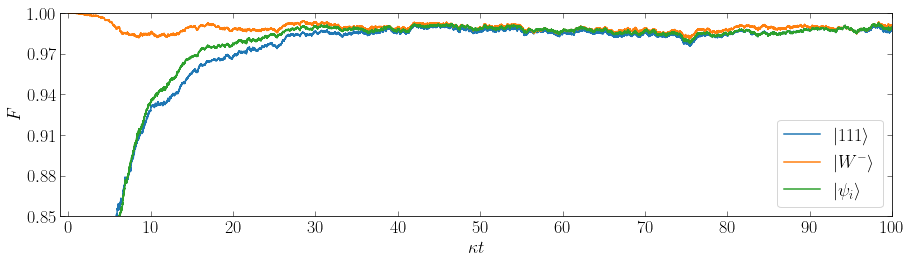

time: 10.8 s


In [3]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=13, h=4)

data0 = np.load('data/data_111.npy')
data1 = np.load('data/data_w_.npy')
data2 = np.load('data/data_psi.npy')
axs.set_xlabel(r'$\kappa t$')
axs.set_ylabel(r'$F$')
axs.plot(data0[0], data0[1], label = r'$| 1 1 1 \rangle$')
axs.plot(data1[0], data1[1], label = r'$| W^{-} \rangle$')
axs.plot(data2[0], data2[1], label = r'$| \psi_i \rangle$')
axs.set_ylim(0.85,1)
axs.set_xlim(-1,100)

axs.tick_params(axis='both', which = 'major', reset = True, direction='in', length = 5, width=0.5, colors='black', grid_color='grey', grid_alpha=0.3)
axs.tick_params(axis='both', which = 'minor', reset = True, direction='in', length = 3, width=0.5, colors='black', grid_color='grey', grid_alpha=0.3)

axs.yaxis.set_ticks(np.linspace(0.85,1,6))
axs.xaxis.set_ticks(np.linspace(0,100,11))

axs.legend()
plt.tight_layout()
plt.show()